In [182]:
import pandas as pd 
import numpy as np
import os 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')
#filepath='C:\\Users\\qian\\Desktop\\python\\DATA SCIENTIST\\Kaggle\\telco customer churn\\input'
filepath='C:\\Users\\LiuMingyue\\Desktop\\telco customer churn\\input'
os.chdir(filepath)
df=pd.read_csv('datasets_13996_18858_WA_Fn-UseC_-Telco-Customer-Churn.csv')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#df_test=pd.read_csv('test.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


<font color='blue'>Tenure is the period that customer has stayed with company. Assume TotalCharges=Tenure*MonthlyCharge

To verify it, calculate the correlation coefficient of them</font>

In [3]:
TotalCharges_cal=df.tenure*df.MonthlyCharges
TotalCharges_cal.corr(df.TotalCharges.map(lambda x:0 if x.isspace() else float(x)))

0.9995605537972277

<font color='blue'> r is close to 1. It means assumption is right </font>

In [183]:
#Replacing spaces with null values in total charges column
df['TotalCharges'] = df["TotalCharges"].replace(" ",np.nan)
df = df[df["TotalCharges"].notnull()]
df = df.reset_index()[df.columns]

#convert to float type
df["TotalCharges"] = df["TotalCharges"].astype(float)

<font color='blue'> split the data into training and test </font>

In [184]:
from sklearn.model_selection import train_test_split
df_x=df.loc[:,'gender':'TotalCharges']
df_y=df.Churn.map(lambda x:1 if x=='Yes' else 0)
x_train, x_test, y_train, y_test = train_test_split(df_x,df_y,test_size=0.2,random_state=1)

<font color='blue'> start to visulize </font>

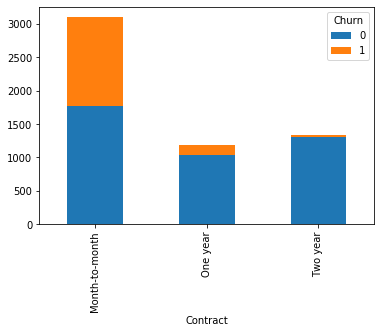

In [18]:
#sns.pairplot(pd.concat([x_train,y_train],axis=1),x_vars=['tenure'],y_vars=['Churn'])
pd.crosstab(x_train.Contract,y_train).plot.bar(stacked=True)

<font color='blue'>Contract affect Churn significantly. Month-to-month customers are much more likely to leave than the other two contracts</font>

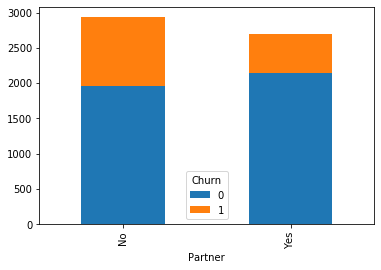

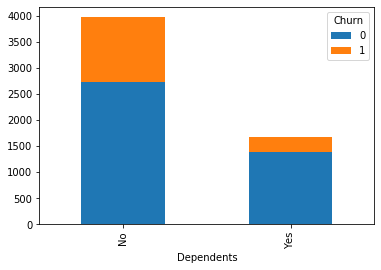

In [31]:
#plt.figure
#plt.figure()
#plt.subplot(1,2,1)
pd.crosstab(x_train.Partner,y_train).plot.bar(stacked=True)
#plt.show()
#plt.subplot(1,2,2)
pd.crosstab(x_train.Dependents,y_train).plot.bar(stacked=True)

<font color='blue'>partner and dependents have similar impact on the result. Customers without partner/dependents are more likely to quit</font>

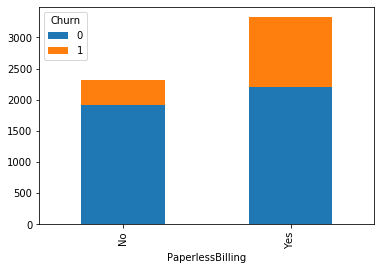

In [36]:
pd.crosstab(x_train.PaperlessBilling,y_train).plot.bar(stacked=True)



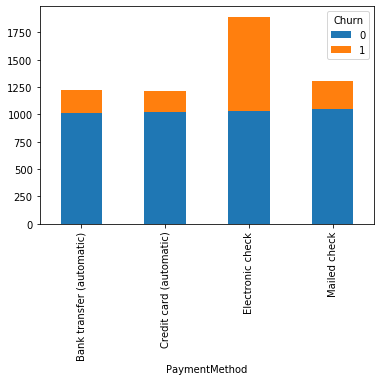

In [37]:
pd.crosstab(x_train.PaymentMethod,y_train).plot.bar(stacked=True)


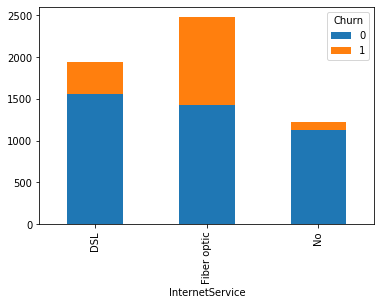

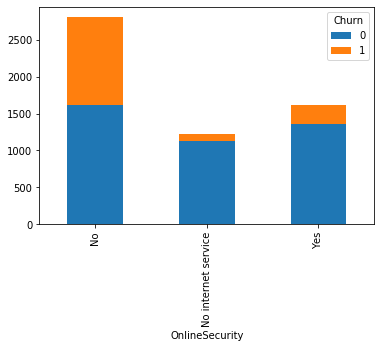

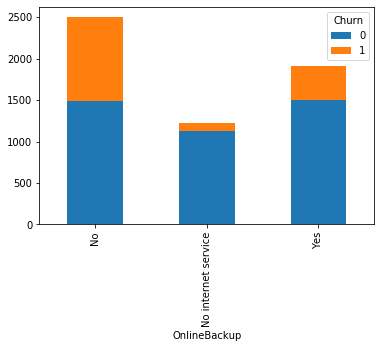

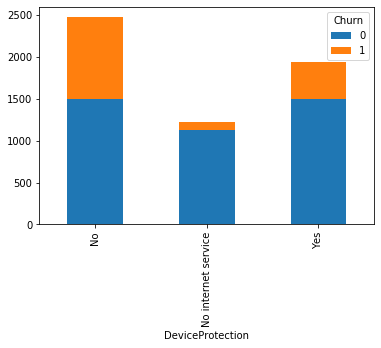

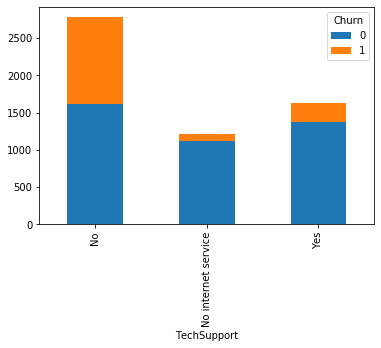

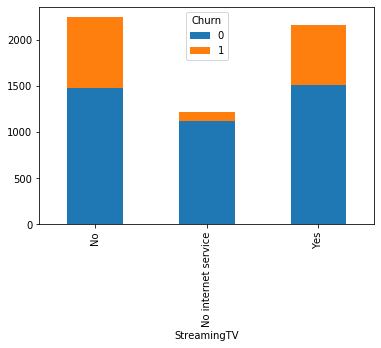

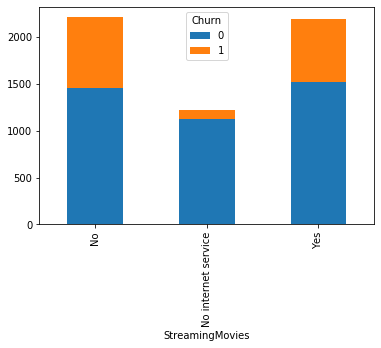

In [44]:
pd.crosstab(x_train.InternetService,y_train).plot.bar(stacked=True)
pd.crosstab(x_train.OnlineSecurity,y_train).plot.bar(stacked=True)
pd.crosstab(x_train.OnlineBackup,y_train).plot.bar(stacked=True)
pd.crosstab(x_train.DeviceProtection,y_train).plot.bar(stacked=True)
pd.crosstab(x_train.TechSupport,y_train).plot.bar(stacked=True)
pd.crosstab(x_train.StreamingTV,y_train).plot.bar(stacked=True)
pd.crosstab(x_train.StreamingMovies,y_train).plot.bar(stacked=True)





<font color='blue'>combine internet related data to see how it relates to churn
It turns out that four internet service shows similar tread: the more service a customer has, the less likely he would leave

two streaming services are similar:no obvious pattern</font>

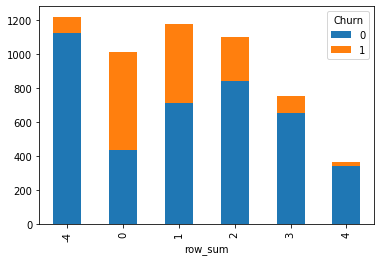

In [72]:
cols=['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport'] #'StreamingTV','StreamingMovies'
#cols=['StreamingTV','StreamingMovies']
internet_event = None
for i in cols:
    tmp=x_train[i].replace('Yes',1)
    tmp=tmp.replace('No',0)
    tmp=tmp.replace('No internet service',-1)
    if internet_event is None:
        internet_event = tmp
    else:
        internet_event = pd.concat([internet_event,tmp],axis=1)    
internet_event['row_sum'] = internet_event.apply(lambda x:x.sum(),axis=1)
pd.crosstab(internet_event['row_sum'],y_train).plot.bar(stacked=True)


<font color='blue'>discrete tenure into categorial value ( 0-1,2-9,10-19,20-39,40+)
    
We can find that the longer the customer stays, the less likely he will quit </font>

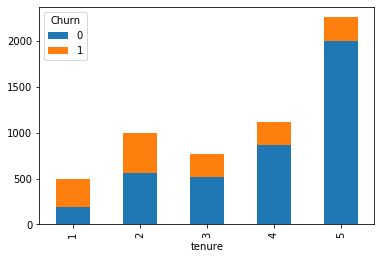

In [13]:
#pd.crosstab(x_train.tenure,y_train).plot.bar(stacked=True)
#sns.distplot(x_train.tenure)
def discret(x):
    if x<2:
        return 1
    elif x<10:
        return 2
    elif x<20:
        return 3
    elif x<40:
        return 4
    else:
        return 5
tenure_group=x_train.tenure.map(discret)
pd.crosstab(tenure_group,y_train).plot.bar(stacked=True)

<font color='blue'>discrete MonthlyCharges into categorial value ( 0-35,35-70,70+)
    
We can find that the more money the customer pays, the more likely he will quit </font>

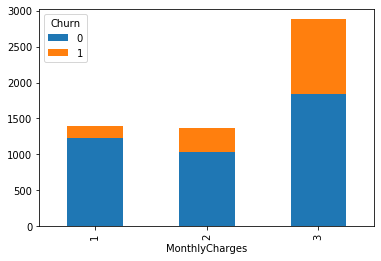

In [19]:
#pd.crosstab(x_train.MonthlyCharges,y_train).plot.bar(stacked=True)
#sns.distplot(x_train.MonthlyCharges)
#x_train.MonthlyCharges.describe()
def discret(x):
    if x<35:
        return 1
    elif x<70:
        return 2
    else:
        return 3

MonthlyCharges_group=x_train.MonthlyCharges.map(discret)
pd.crosstab(MonthlyCharges_group,y_train).plot.bar(stacked=True)

<font color='blue'> Missing data</font>

In [43]:
#x_train.isnull().sum()
x_test.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

<font color='blue'>No missing data in both training and test training set</font>

# feature engineering
<font color='blue'>  

combine partner and dependents

combine four internet extra service

combine two streaming service
    
combine two phone service (drop phoneservice)

drop total charges</font>

<font color='blue'>  
transform str to int: gender,partner,dependents, two phone service, seven internet service,contract,paperlessbilling,payment method</font>

In [185]:
x_train.loc[:,'gender'] = x_train.gender.map({'Male':0,'Female':1})
x_test.loc[:,'gender'] = x_test.gender.map({'Male':0,'Female':1})
x_train.loc[:,'Partner'] = x_train.Partner.map({'No':0,'Yes':1})
x_test.loc[:,'Partner'] = x_test.Partner.map({'No':0,'Yes':1})
x_train.loc[:,'Dependents'] = x_train.Dependents.map({'No':0,'Yes':1})
x_test.loc[:,'Dependents'] = x_test.Dependents.map({'No':0,'Yes':1})
#x_train.PhoneService = x_train.PhoneService.map({'No':0,'Yes':1})
#x_test.PhoneService = x_test.PhoneService.map({'No':0,'Yes':1})
x_train.loc[:,'MultipleLines'] = x_train.MultipleLines.map({'No phone service':0,'No':1,'Yes':2})
x_test.loc[:,'MultipleLines'] = x_test.MultipleLines.map({'No phone service':0,'No':1,'Yes':2})
x_train.loc[:,'InternetService'] = x_train.InternetService.map({'No':0,'Fiber optic':1,'DSL':2})
x_test.loc[:,'InternetService'] = x_test.InternetService.map({'No':0,'Fiber optic':1,'DSL':2})
x_train.loc[:,'OnlineSecurity'] = x_train.OnlineSecurity.map({'No':0,'No internet service':-1,'Yes':1})
x_test.loc[:,'OnlineSecurity'] = x_test.OnlineSecurity.map({'No':0,'No internet service':-1,'Yes':1})
x_train.loc[:,'OnlineBackup'] = x_train.OnlineBackup.map({'No':0,'No internet service':-1,'Yes':1})
x_test.loc[:,'OnlineBackup'] = x_test.OnlineBackup.map({'No':0,'No internet service':-1,'Yes':1})
x_train.loc[:,'DeviceProtection'] = x_train.DeviceProtection.map({'No':0,'No internet service':-1,'Yes':1})
x_test.loc[:,'DeviceProtection'] = x_test.DeviceProtection.map({'No':0,'No internet service':-1,'Yes':1})
x_train.loc[:,'TechSupport'] = x_train.TechSupport.map({'No':0,'No internet service':-1,'Yes':1})
x_test.loc[:,'TechSupport'] = x_test.TechSupport.map({'No':0,'No internet service':-1,'Yes':1})
x_train.loc[:,'StreamingTV'] = x_train.StreamingTV.map({'No':0,'No internet service':-1,'Yes':1})
x_test.loc[:,'StreamingTV'] = x_test.StreamingTV.map({'No':0,'No internet service':-1,'Yes':1})
x_train.loc[:,'StreamingMovies'] = x_train.StreamingMovies.map({'No':0,'No internet service':-1,'Yes':1})
x_test.loc[:,'StreamingMovies'] = x_test.StreamingMovies.map({'No':0,'No internet service':-1,'Yes':1})
x_train.loc[:,'Contract'] = x_train.Contract.map({'Month-to-month':0,'One year':1,'Two year':2})
x_test.loc[:,'Contract'] = x_test.Contract.map({'Month-to-month':0,'One year':1,'Two year':2})
x_train.loc[:,'PaperlessBilling'] = x_train.PaperlessBilling.map({'No':0,'Yes':1})
x_test.loc[:,'PaperlessBilling'] = x_test.PaperlessBilling.map({'No':0,'Yes':1})
x_train.loc[:,'PaymentMethod'] = x_train.PaymentMethod.map({'Electronic check':0,'Mailed check':1,'Bank transfer (automatic)':2,'Credit card (automatic)':3})
x_test.loc[:,'PaymentMethod'] = x_test.PaymentMethod.map({'Electronic check':0,'Mailed check':1,'Bank transfer (automatic)':2,'Credit card (automatic)':3})

In [186]:
# combine partner and dependents
x_train.loc[:,'Part_depend'] = x_train.Partner+x_train.Dependents
x_test.loc[:,'Part_depend'] = x_test.Partner+x_test.Dependents

# combine four internet extra service
x_train.loc[:,'InternetExtra'] = x_train.OnlineSecurity+x_train.OnlineBackup+x_train.DeviceProtection+x_train.TechSupport
x_test.loc[:,'InternetExtra'] = x_test.OnlineSecurity+x_test.OnlineBackup+x_test.DeviceProtection+x_test.TechSupport

# combine two streaming service
x_train.loc[:,'StreamingService'] = x_train.StreamingTV+x_train.StreamingMovies
x_test.loc[:,'StreamingService'] = x_test.StreamingTV+x_test.StreamingMovies



In [187]:
# drop Partner,Dependents,phoneservice, 4 internet service and two streaming service
x_train.drop(['Partner', 'Dependents','PhoneService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies'], axis=1,inplace=True)
x_test.drop(['Partner', 'Dependents','PhoneService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies'], axis=1,inplace=True)

In [192]:
x_train.head(10)

,gender,SeniorCitizen,tenure,MultipleLines,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Part_depend,InternetExtra,StreamingService
3451,1,0,1,1,0,0,1,1,19.50,19.50,0,-4,-2
611,0,0,66,1,0,2,0,1,20.55,1357.10,1,-4,-2
588,0,0,71,2,2,2,0,0,90.40,6668.05,2,4,2
2680,1,0,72,2,1,2,0,2,100.65,7334.05,1,3,1
1544,0,0,1,1,2,0,1,1,45.85,45.85,0,0,0
2883,1,1,1,1,1,0,1,0,71.00,71.00,1,0,0
1072,1,0,59,2,1,0,1,2,96.65,5580.80,2,2,1
6926,1,0,28,0,2,0,1,1,35.75,961.40,0,2,0
6417,1,0,41,1,2,1,0,2,50.05,2029.05,0,1,0
997,1,0,7,1,1,0,1,0,95.35,660.90,0,1,2


# Training model

based on 10-fold cross validation, random forest achieves the highest accuracy rate

In [189]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# decision tree
tree_clf = DecisionTreeClassifier()
#tree_clf.fit(x_train,y_train)
#score_tree = tree_clf.score(x_train,y_train)
#score_tree = tree_clf.score(x_test,y_test)
score_tree = cross_val_score(tree_clf, x_train, y_train, cv=10)

#random forest
forest_clf = RandomForestClassifier(n_estimators=100,max_depth=5,random_state=1)
#forest_clf.fit(x_train,y_train)
#score_forest = forest_clf.score(x_train,y_train)
#score_forest = forest_clf.score(x_test,y_test)
score_forest = cross_val_score(forest_clf, x_train, y_train, cv=10)

# logistic regression
lr_clf = LogisticRegression()
#lr_clf.fit(x_train,y_train)
#score_lr = lr_clf.score(x_train,y_train)
#score_lr = lr_clf.score(x_test,y_test)
score_lr = cross_val_score(lr_clf, x_train, y_train, cv=10)

#svm
svm_clf = SVC()
#svm_clf.fit(x_train,y_train)
#score_svm = svm_clf.score(x_train,y_train)
#score_svm = svm_clf.score(x_test,y_test)
score_svm = cross_val_score(svm_clf, x_train, y_train, cv=10)

print('decision tree= %f, random forest=%f, logistic regression=%f, svm=%f' % (score_tree.mean(), score_forest.mean(),score_lr.mean(),score_svm.mean()))

decision tree= 0.722850, random forest=0.798759, logistic regression=0.791293, svm=0.732800


In [190]:
# try to find the best hyper parameter for random forest
RF = RandomForestClassifier(random_state=1)
RF_para={'n_estimators':[10,50,100],'max_depth':[1,2,3,4,5],'criterion':['gini','entropy']}
GSRF = GridSearchCV(RF,RF_para,scoring='accuracy',cv=10)
GSRF.fit(x_train,y_train)
GSRF.best_score_
# find the best paras of gini,n_estimators=50,max_depth=5



0.8000034765459569

In [191]:
from sklearn.metrics import accuracy_score
#predict test
pred = GSRF.predict(x_test)
accuracy_score(y_test,pred)

0.798862828713575